### Momentum + backtesting

In [3]:
from trading_rookie.data.get_data import DataDownloader
start = "2024-01-01"
end = "2026-01-01"

data_downloader = DataDownloader()
df = data_downloader.yahoo('AAPL', start, end, '1d')
df.head()

,Open,High,Low,Close,Volume,Adj_close
Date,,,,,,
2024-01-02,187.149994,188.440002,183.889999,185.639999,82488700,183.731293
2024-01-03,184.220001,185.880005,183.429993,184.250000,58414500,182.355637
2024-01-04,182.149994,183.089996,180.880005,181.910004,71983600,180.039658
2024-01-05,181.990005,182.759995,180.169998,181.179993,62379700,179.317184
2024-01-08,182.089996,185.600006,181.500000,185.559998,59144500,183.652130


In [4]:
import seaborn as sns
import numpy as np
price = df.Close

log_return = np.log(price).diff()

mom_20 = log_return.rolling(20).mean()

signal = (mom_20 > 0).astype(int) 

pos = signal.shift(1).fillna(0)

strategy_return = pos * log_return

turnover = pos.diff().abs()

cost = 0.001
strategy_ret_net = strategy_return - turnover * cost

print(f"Strategy return: {strategy_return.sum():.2%}")
print(f"Strategy return after cost: {strategy_ret_net.sum():.2%}")


Strategy return: 27.49%
Strategy return after cost: 23.49%


Sharpe Ratio: 1.12
Sharpe Ratio (Net): 0.96
Max Drawdown: -18.86%


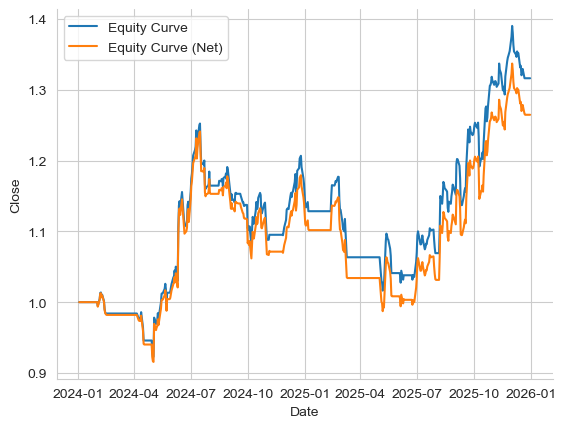

In [5]:
cumulative_strategy_return = strategy_return.cumsum()
cumulative_strategy_return_net = strategy_ret_net.cumsum()

equity_curve = np.exp(cumulative_strategy_return)
equity_curve_net = np.exp(cumulative_strategy_return_net)

sharpe = strategy_return.mean() / strategy_return.std() * np.sqrt(price.shape[0])
sharpe_net = strategy_ret_net.mean() / strategy_ret_net.std() * np.sqrt(price.shape[0])

roll_max = equity_curve.cummax()
drawdown = equity_curve / roll_max - 1
max_dd = drawdown.min()

print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Sharpe Ratio (Net): {sharpe_net:.2f}")
print(f"Max Drawdown: {max_dd:.2%}")

sns.set_style("whitegrid")
sns.lineplot(data=equity_curve, label="Equity Curve")
sns.lineplot(data=equity_curve_net, label="Equity Curve (Net)")
sns.despine()

---

### Walk-forward backtest

In [6]:
start = "2010-01-01"
end = "2026-01-01"

data = data_downloader.yahoo('AAPL', start, end, '1d')
data.head()

,Open,High,Low,Close,Volume,Adj_close
Date,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,493729600,6.412383
2010-01-05,7.664286,7.699643,7.616071,7.656429,601904800,6.423469
2010-01-06,7.656429,7.686786,7.526786,7.534643,552160000,6.321294
2010-01-07,7.562500,7.571429,7.466071,7.520714,477131200,6.309609
2010-01-08,7.510714,7.571429,7.466429,7.570714,447610800,6.351558


In [9]:
import numpy as np
import pandas as pd

cost = 0.001  # 10 bps per trade (single-side cost per position change)
N_candidates = [20, 60, 120]
train_years = 3
test_years = 1

price = data.Close.dropna()
ret = np.log(price).diff()

dates = ret.dropna().index
start_year = dates.min().year
end_year = dates.max().year

all_oos = []   # store out-of-sample net strategy returns per test window
chosen_N = []  # store chosen parameter per window

def run_mom_strategy(ret_series, N, cost):
    mom = ret_series.rolling(N).sum()
    signal = (mom > 0).astype(int)          # long/flat
    pos = signal.shift(1).fillna(0)         # avoid look-ahead
    strat = pos * ret_series

    turnover = pos.diff().abs().fillna(0)   # 1 when entering/exiting
    strat_net = strat - turnover * cost
    return strat_net

for train_start in range(start_year, end_year - (train_years + test_years) + 2):
    train_end = train_start + train_years - 1
    test_start = train_end + 1
    test_end = test_start + test_years - 1

    train_mask = (ret.index.year >= train_start) & (ret.index.year <= train_end)
    test_mask  = (ret.index.year >= test_start) & (ret.index.year <= test_end)

    ret_train = ret.loc[train_mask].dropna()
    ret_test  = ret.loc[test_mask].dropna()

    if len(ret_train) < 252 or len(ret_test) < 50:
        continue

    best_N = None
    best_sharpe = -np.inf
	
    for N in N_candidates:
        s = run_mom_strategy(ret_train, N, cost).dropna()
        if s.std() == 0 or len(s) < 50:
            continue
        sharpe = s.mean() / s.std() * np.sqrt(252)
        if sharpe > best_sharpe:
            best_sharpe = sharpe
            best_N = N
	
    if best_N is None:
        continue

    oos = run_mom_strategy(ret_test, best_N, cost).dropna() # out-of-sample strategy returns
    all_oos.append(oos)
    chosen_N.append((train_start, train_end, test_start, test_end, best_N, best_sharpe))

oos_ret = pd.concat(all_oos).sort_index()
equity = np.exp(oos_ret.cumsum())

sharpe_oos = oos_ret.mean() / oos_ret.std() * np.sqrt(252)
roll_max = equity.cummax()
drawdown = equity / roll_max - 1
max_dd = drawdown.min()

print("OOS Sharpe:", sharpe_oos)
print("OOS Max Drawdown:", max_dd)
print("Number of WF windows:", len(chosen_N))

chosen_df = pd.DataFrame(chosen_N, columns=["train_start","train_end","test_start","test_end","best_N","train_sharpe"])
print(chosen_df)

OOS Sharpe: 0.9545082946955907
OOS Max Drawdown: -0.2636523458369344
Number of WF windows: 13
    train_start  train_end  test_start  test_end  best_N  train_sharpe
0          2010       2012        2013      2013      60      1.073162
1          2011       2013        2014      2014      60      1.075569
2          2012       2014        2015      2015      20      1.203705
3          2013       2015        2016      2016     120      0.909812
4          2014       2016        2017      2017     120      0.909827
5          2015       2017        2018      2018     120      1.108717
6          2016       2018        2019      2019      20      0.840814
7          2017       2019        2020      2020      20      1.480927
8          2018       2020        2021      2021      20      1.547349
9          2019       2021        2022      2022      20      1.830346
10         2020       2022        2023      2023      20      0.708795
11         2021       2023        2024      2024      